In [ ]:
from google.colab import drive

drive.mount("/content/drive")

%cd "/content/drive/MyDrive/Implement Classic Papers/Attention Is All You Need"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/Implement Classic Papers/Attention Is All You Need


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import math

from torch.nn import CrossEntropyLoss
from torch.optim import Adam
from torch.optim.lr_scheduler import LambdaLR
from torch.utils.data import DataLoader, Dataset
from typing import List, Callable, Optional, Literal
from copy import deepcopy as dc
from transformers import AutoTokenizer
from tqdm import tqdm

torch.cuda.is_available()

MAIN_DIR = os.getcwd()
DATA_DIR = os.path.join(MAIN_DIR, "eng_vie")

with open(os.path.join(DATA_DIR, "vi_sents"), "r", encoding="utf-8") as f:
    vie_sentences = f.readlines()

with open(os.path.join(DATA_DIR, "en_sents"), "r", encoding="utf-8") as f:
    eng_sentences = f.readlines()

In [ ]:
for i in range(5):
    print(eng_sentences[i], vie_sentences[i])

Please put the dustpan in the broom closet
 xin vui lòng đặt người quét rác trong tủ chổi

Be quiet for a moment.
 im lặng một lát

Read this
 đọc này

Tom persuaded the store manager to give him back his money.
 tom thuyết phục người quản lý cửa hàng trả lại tiền cho anh ta.

Friendship consists of mutual understanding
 tình bạn bao gồm sự hiểu biết lẫn nhau



# Model Architecture

In [ ]:
def clones(module: nn.Module, N: List):
    return nn.ModuleList([dc(module) for _ in range(N)])

def get_masked_attention_mask(seq_len: str):
    mask = torch.ones(size=(1, seq_len, seq_len), dtype=torch.uint8)
    mask = mask.triu(diagonal=1)
    return mask == 0

In [ ]:
class MultiHeadedAttention(nn.Module):
    def __init__(
        self,
        d_model: int = 512,
        h: int = 8,
        d_k: Optional[int] = None,
        d_v: Optional[int] = None,
        dropout: float=0.1
    ):
        super(MultiHeadedAttention, self).__init__()
        self.h = h
        self.d_model = d_model

        if not d_k:
            assert self.d_model % h == 0
            self.d_k = self.d_model // h
        else:
            self.d_k = d_k

        self.d_q = self.d_k
        self.d_v = d_v or self.d_k

        self.Q = nn.Linear(self.d_model, self.d_q * h)
        self.K = nn.Linear(self.d_model, self.d_k * h)
        self.V = nn.Linear(self.d_model, self.d_v * h)
        self.O = nn.Linear(self.d_v * h, self.d_model)

        self.dropout = nn.Dropout(p=dropout)
        self.attn = None # For visualization of attention mechanism

    def self_attention(
        self, query: torch.tensor, key: torch.tensor, value: torch.tensor, mask=None, dropout=None
    ):
        # Query & Key: (batch_size, n_head, seq_len, d_k) -> Key Transpose = (batch_size, n_head, d_k, seq_len)
        # Value: (batch_size, n_head, seq_len, d_v)
        # Mask: (batch_size, 1, seq_len, seq_len)
        d_k = query.size(-1)
        self_attention = torch.matmul(query, key.transpose(-2, -1)) / math.sqrt(d_k) # (batch_size, n_head, seq_len, seq_len)
        if mask is not None:
            self_attention = self_attention.masked_fill(mask==0, value=-1e9)
        attention_weights = self_attention.softmax(dim=-1) # (batch_size, n_head, seq_len, seq_len)
        if dropout:
            attention_weights = dropout(attention_weights)
        return torch.matmul(attention_weights, value), attention_weights # (batch_size, n_head, seq_len, d_v)

    def forward(
        self, query, key, value, mask=None
    ):
        # Encoder & Decoder attention unit: Query = Key = Value = (batch_size, seq_len, emb_size)
        # Decoder masked attention unit: Query = (batch_size, tgt_len, emb_size) , K = V = (batch_size, src_len, emb_size)
        # Mask: For masked attention = (batch_size, padded_tgt_len, padded_tgt_len)
        # Mask: For self attention = (1, 1 tgt_len/src_len)

        if mask is not None:
            mask = mask.unsqueeze(1) # (batch_size, 1, tgt_len, tgt_len)

        batch_size = query.size(0)

        query = self.Q(query) # (batch_size, seq_len, d_q * h)
        query = query.view(batch_size, -1, self.h, self.d_q) # (batch_size, seq_len, h, d_q)
        query = query.transpose(1, 2) # (batch_size, h, seq_len, d_q)

        key = self.K(key) # (batch_size, seq_len, d_k * h)
        key = key.view(batch_size, -1, self.h, self.d_k)
        key = key.transpose(1, 2)

        value = self.V(value) # (batch_size, seq-len, d_v * h)
        value = value.view(batch_size, -1, self.h, self.d_v)
        value = value.transpose(1, 2) # (batch_size, h, value_seq_len, )

        x, self.attn = self.self_attention(query, key, value, mask, self.dropout) # x = (batch_size, n_head, seq_len, d_v)
        x = x.transpose(1,2).contiguous().view(batch_size, -1, self.h * self.d_v)
        output = self.O(x) # (batch_size, seq_len, d_model)

        del query
        del key
        del value

        return output

class PointWiseFeedForward(nn.Module):
    def __init__(
        self, d_model: int=512, d_ff: Optional[int] = None, dropout: float=0.1
    ):
        super(PointWiseFeedForward, self).__init__()
        self.d_model=d_model
        self.d_ff = d_ff or 4 * d_model
        self.linear1 = nn.Linear(self.d_model, self.d_ff)
        self.linear2 = nn.Linear(self.d_ff, self.d_model)
        self.dropout = nn.Dropout(p=dropout)

    def forward(self, x):
        # Input batch: (batch_size, seq-len, d_model)
        x = self.linear1(x)
        x = F.gelu(x) # Original = relu
        x = self.dropout(x)
        x = self.linear2(x)
        return x

class LayerNorm(nn.Module):
    def __init__(
        self, d_model: int, eps: float=1e-8
        ):
        super(LayerNorm, self).__init__()
        self.scaling_factor = nn.Parameter(torch.ones(d_model))
        self.bias_factor = nn.Parameter(torch.zeros(d_model))
        self.eps = eps

    def forward(self, x):
        # (batch_size, seq_len, d_model)
        mean = x.mean(dim=-1, keepdim=True)
        std = x.std(dim=-1, keepdim=True)
        activations = (x - mean) / (std + self.eps)
        return self.scaling_factor * activations + self.bias_factor # Point-wise additional and multiplication

class SubLayerConnection(nn.Module):
    def __init__(
        self, d_model: int, eps: float=1e-6, dropout: float=0.1
    ):
        super(SubLayerConnection, self).__init__()
        self.d_model = d_model
        self.layer_norm = LayerNorm(d_model=d_model, eps=eps)
        self.dropout = nn.Dropout(p=dropout)

    def forward(
        self, x: torch.Tensor, sub_layer: Callable
    ):
        return self.layer_norm(x + self.dropout(sub_layer(x)))

class EncoderLayer(nn.Module):
    def __init__(
        self, d_model: int=512, h: int=8
    ):
        super(EncoderLayer, self).__init__()
        self.d_model = d_model
        self.multihead_attention = MultiHeadedAttention(d_model=d_model, h=h)
        self.feed_forward = PointWiseFeedForward(d_model=d_model)
        self.att_sublayer = SubLayerConnection(d_model=d_model)
        self.ff_sublayer = SubLayerConnection(d_model=d_model)

    def forward(
        self, x: torch.Tensor, mask: Optional[torch.Tensor]=None
    ):
        x = self.att_sublayer(x, lambda x: self.multihead_attention(query=x, key=x, value=x, mask=mask))
        x = self.ff_sublayer(x, self.feed_forward)
        return x

class Encoder(nn.Module):
    def __init__(
        self, n: int=6, h: int=8, d_model: int=512
    ):
        super(Encoder, self).__init__()
        self.N, self.H, self.d_model = n, h, d_model
        self.layers = clones(EncoderLayer(d_model=d_model, h=self.H), self.N)

    def forward(
        self, x: torch.Tensor, mask: Optional[torch.Tensor]=None
    ):
        # Input = (batch_size, seq_len, d_model)
        # Ouput = (batch_size, seq_len, d_model)
        for layer in self.layers:
            x = layer(x, mask)
        return x

class DecoderLayer(nn.Module):
    def __init__(
        self, d_model: int=512, h: int=8
    ):
        super(DecoderLayer, self).__init__()
        self.d_model = d_model
        self.masked_multihead_attention = MultiHeadedAttention(d_model=d_model, h=h)
        self.multihead_attention = MultiHeadedAttention(d_model=d_model, h=h)
        self.feed_forward = PointWiseFeedForward(d_model=d_model)
        self.masked_att_sublayer = SubLayerConnection(d_model=d_model)
        self.att_sublayer = SubLayerConnection(d_model=d_model)
        self.ff_sublayer = SubLayerConnection(d_model=d_model)

    def forward(
        self,
        decoder_input: torch.Tensor,
        encoder_output: torch.Tensor,
        src_mask: Optional[torch.Tensor]=None,
        tgt_mask: Optional[torch.Tensor]=None
    ):
        # Decoder input: (bs, tgt_seq_len, d_model)
        # Encoder ouput: (bs, src_seq_len, d_model)
        x = self.masked_att_sublayer(
            decoder_input,
            lambda x: self.masked_multihead_attention(query=x, key=x, value=x, mask=tgt_mask)
            )
        x = self.att_sublayer(
            x,
            lambda x: self.multihead_attention(query=x, key=encoder_output, value=encoder_output, mask=src_mask)
            )
        x = self.ff_sublayer(x, self.feed_forward)
        return x

class Decoder(nn.Module):
    def __init__(
        self, n: int=6, h: int=8, d_model: int=512
    ):
        super(Decoder, self).__init__()
        self.N, self.H, self.d_model = n, h, d_model
        self.layers = clones(DecoderLayer(d_model=d_model, h=self.H), self.N)

    def forward(
        self,
        x: torch.Tensor,
        encoder_output: torch.Tensor,
        src_mask: Optional[torch.Tensor]=None,
        tgt_mask: Optional[torch.Tensor]=None
    ):
        # x: (bs, tgt_seq_len, d_model)
        # encoder_output: (bs, src_seq_len, d_model)
        for layer in self.layers:
            x = layer(x, encoder_output, src_mask, tgt_mask)
        return x

class TokenEmbeddings(nn.Module):
    def __init__(
        self, d_model: int, vocab_size: int
    ):
        super(TokenEmbeddings, self).__init__()
        self.d_model, self.vocab_size = d_model, vocab_size
        self.embeddings = nn.Embedding(
            num_embeddings=vocab_size,
            embedding_dim=d_model, padding_idx=0
        )

    def forward(
        self, inputs: torch.tensor
    ):
        return self.embeddings(inputs) * math.sqrt(self.d_model)

class Generator(nn.Module):
    def __init__(self, d_model, vocab_size):
        super(Generator, self).__init__()
        self.proj = nn.Linear(d_model, vocab_size)

    def forward(self, x):
        return F.log_softmax(self.proj(x), dim=-1)

class SinusoidalPositionalEncoding(nn.Module):
    def __init__(
        self, d_model: int, dropout: float=0.1, max_len: int=5000
    ):
        super(SinusoidalPositionalEncoding, self).__init__()
        self.d_model = d_model
        self.dropout = nn.Dropout(p=dropout)
        pe = torch.zeros(size=(max_len, d_model)) # (max_len, d_model)
        const_term = math.log(10000) / d_model
        div_terms = torch.exp(-torch.arange(0, d_model, 2) * const_term) # (d_model//2)
        positions = torch.arange(0, max_len).unsqueeze(1) # (max_len, 1)
        pe[:, ::2] = torch.sin(positions*div_terms)  # sin(pos * div_term)
        pe[:, 1::2] = torch.cos(positions*div_terms)  # sin(pos * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer("pe", pe)

    def forward(
        self, x: torch.tensor
    ):
        assert x.size(2) == self.d_model
        # Input sequence: (batch_size, seq_length)
        x = x + self.pe[:, : x.size(1), :].requires_grad_(False)
        return self.dropout(x)

class LearnablePositionalEncoding(nn.Module):
    def __init__(
        self, d_model: int, dropout: float=0.1, max_len: int=5000
    ):
        super(LearnablePositionalEncoding, self).__init__()
        self.d_model = d_model
        self.dropout = nn.Dropout(p=dropout)
        self.embeddings = nn.Embedding(max_len, d_model)

    def forward(
        self, x
    ):
        assert x.size(2) == self.d_model
        embs = self.embeddings(torch.arange(0, x.size(1), 1))
        x = x + embs
        return self.dropout(x)

# Need to implement separate encode and decode functions as we only want to encode src sequence once for each new tgt token.
# Need to implement forward pass end-to-end so that we can backpropagate end-to-end from decoder to encoder.
class TransformersSeqToSeq(nn.Module):
    def __init__(
        self,
        n: int=6,
        h: int=8,
        d_model: int=512,
        src_vocab_size: int=30000,
        tgt_vocab_size: int=30000,
        share_embeddings: bool=False,
        max_tokens: int=4096
    ):
        super(TransformersSeqToSeq, self).__init__()
        self.n, self.h, self.d_model = n, h, d_model
        self.encoder = Encoder(n=n, h=h, d_model=d_model)
        self.decoder = Decoder(n=n, h=h, d_model=d_model)
        self.src_embeddings = TokenEmbeddings(d_model=d_model, vocab_size=src_vocab_size)
        if share_embeddings:
            self.tgt_embeddings = self.src_embeddings
            self.generator = Generator(d_model=d_model, vocab_size=src_vocab_size)
        else:
            self.tgt_embeddings = TokenEmbeddings(d_model=d_model, vocab_size=tgt_vocab_size)
            self.generator = Generator(d_model=d_model, vocab_size=tgt_vocab_size)

        self.positional_encoding = SinusoidalPositionalEncoding(d_model=d_model, max_len=5000)
        for p in self.parameters():
            if p.dim() > 1:
                nn.init.xavier_uniform_(p)
        self.max_tokens=max_tokens

    def encode(
        self, src: torch.tensor, src_mask: Optional[torch.tensor] = None
    ):
        # src = (batch_size, src_seq_len)
        src_token_embeddings = self.src_embeddings(src)
        src_embeddings = self.positional_encoding(src_token_embeddings)
        return self.encoder(x=src_embeddings, mask=src_mask)

    def decode(
        self, tgt, memory, src_mask, tgt_mask
    ):
        # tgt = (batch_size, tgt_seq_len)
        # memory = (batch_size, src_seq_len, d_model)
        tgt_token_embeddings = self.tgt_embeddings(tgt)
        tgt_embeddings = self.positional_encoding(tgt_token_embeddings)
        decoder_output = self.decoder(x=tgt_embeddings, encoder_output=memory, src_mask=src_mask, tgt_mask=tgt_mask) # (batch_size, seq_len, d_model)
        probs = self.generator(decoder_output)
        return probs

    def forward(
        self, src: torch.tensor, tgt: torch.tensor, src_mask: Optional[torch.tensor] = None, tgt_mask: Optional[torch.tensor] = None
    ):
        # src = (batch_size, src_seq_len)
        # tgt = (batch_size, tgt_seq_len)
        memory = self.encode(src, src_mask)
        probs = self.decode(tgt=tgt, memory=memory, src_mask=src_mask, tgt_mask=tgt_mask)
        return probs

    def greedy_decode(
        self,
        src: torch.tensor,
        src_mask: Optional[torch.tensor] = None,
        max_tokens: Optional[int] = None,
        cls_token_id: int = 101,
        eos_token_id: int = 102,
    ):
        device = next(self.parameters()).device
        self.eval()
        max_tokens = max_tokens or self.max_tokens

        if src.ndim == 1:
            src = src.unsqueeze(0)

        batch_size = src.size(0)
        encoder_output = self.encode(src, src_mask)

        tgt = torch.ones(size=(batch_size, 1), dtype=torch.long, device=device) * cls_token_id

        current_token = 1
        is_finished = torch.zeros(batch_size, dtype=torch.bool, device=device)

        while current_token <= max_tokens and (not is_finished.all()):
            tgt_mask = get_masked_attention_mask(tgt.size(-1)).to(device)
            last_probs = self.decode(
                tgt=tgt,
                memory=encoder_output,
                src_mask=src_mask,
                tgt_mask=tgt_mask)[:, -1, :]

            next_token_id = last_probs.argmax(dim=-1)
            tgt = torch.cat([tgt, next_token_id.unsqueeze(-1)], dim=-1)
            is_finished = is_finished | (next_token_id == eos_token_id)
            current_token += 1

        preds = []
        for pred in tgt:
            token_seq = []
            for token_id in pred:
                token_seq.append(token_id.item())
                if token_id.item() == eos_token_id:
                    break
            preds.append(token_seq)
        return preds

In [ ]:
def test_layer_normalization():
    batch_size = 3
    seq_len = 10
    d_model = 4
    eps = 1

    inputs = torch.stack([torch.arange(0, seq_len, dtype=torch.float32) for _ in range(d_model)])
    inputs = inputs.transpose(0, 1)

    scaling_factors = nn.Parameter(torch.tensor([1,2,3,4], dtype=torch.float32))
    bias_factors = nn.Parameter(torch.tensor([1,2,3,4], dtype=torch.float32))
    layer_norm = LayerNorm(d_model=d_model, eps=eps)
    layer_norm.scaling_factor = scaling_factors
    layer_norm.bias_factor = bias_factors

    expected_output = torch.stack([torch.tensor([1,2,3,4], dtype=torch.float32) for _ in range(seq_len)])
    output = layer_norm(inputs)
    assert torch.equal(output, expected_output)

def test_teacher_encoder_decoder():
    src_vocab_size = 300
    tgt_vocab_size = 200
    n = 6
    h = 8
    d_model = 512
    src_len = 20
    tgt_len = 30
    batch_size = 4
    max_tokens = 4096
    model = TransformersSeqToSeq(
        n=n, h=h, d_model=d_model,
        src_vocab_size=src_vocab_size, tgt_vocab_size=tgt_vocab_size,
        max_tokens=max_tokens
        )

    src = torch.randint(0, src_len, size=(batch_size, src_len))
    tgt = torch.randint(0, tgt_len, size=(batch_size, tgt_len))
    outputs = model(src, tgt)
    assert outputs.size() == torch.Size([batch_size, tgt_len, tgt_vocab_size])

def test_single_generate():
    model_args = dict(
        src_vocab_size = 20, tgt_vocab_size = 10, n = 2
    )
    model = TransformersSeqToSeq(
        **model_args
    )
    model.eval()
    src = torch.arange(3,11,1).unsqueeze(0)
    src_mask = torch.ones(size=(1, 1, src.size(-1)))
    encoder_output = model.encode(src, src_mask)
    max_tokens = 15
    tgt = [1]
    current_token = 1
    while current_token <= max_tokens:
        tgt_seq = torch.LongTensor([tgt])
        tgt_mask = get_masked_attention_mask(tgt_seq.size(-1))
        last_probs = model.decode(
            tgt=tgt_seq,
            memory=encoder_output,
            src_mask=src_mask,
            tgt_mask=tgt_mask)[:, -1, :]
        assert last_probs.size() == torch.Size([1, 10])
        next_token_id = last_probs.argmax(dim=-1).item()
        tgt.append(next_token_id)
        current_token += 1

    assert len(tgt) - 1 == max_tokens

def test_batch_generate():

    from torch.nn.utils.rnn import pad_sequence

    model_args = dict(
        src_vocab_size = 20, tgt_vocab_size = 10, n = 2
    )

    model = TransformersSeqToSeq(**model_args)
    model.eval()

    batch_size = 5

    src = [torch.arange(3, a) for a in range(7, 7 + batch_size)]

    SRC_PAD_TOKEN_ID = 1
    TGT_CLS_TOKEN_ID = 0
    TGT_EOS_TOKEN_ID = 2

    src = pad_sequence(src, batch_first=True, padding_value=SRC_PAD_TOKEN_ID)
    src_mask = torch.zeros_like(src)
    src_mask = src_mask.masked_fill(src!=SRC_PAD_TOKEN_ID, 1).unsqueeze(-2)
    encoder_output = model.encode(src, src_mask)

    max_tokens = 15

    tgt = torch.ones(size=(batch_size, 1), dtype=torch.long) * TGT_CLS_TOKEN_ID
    current_token = 1

    is_finished = torch.zeros(batch_size, dtype=torch.bool)

    while current_token <= max_tokens and (not is_finished.all()):
        tgt_mask = get_masked_attention_mask(tgt.size(-1))
        last_probs = model.decode(
            tgt=tgt,
            memory=encoder_output,
            src_mask=src_mask,
            tgt_mask=tgt_mask)[:, -1, :]

        next_token_id = last_probs.argmax(dim=-1)
        tgt = torch.cat([tgt, next_token_id.unsqueeze(-1)], dim=-1)
        is_finished = is_finished | (next_token_id == TGT_EOS_TOKEN_ID)
        current_token += 1

    if not is_finished.all():
        assert tgt.size() == torch.Size([batch_size, max_tokens + 1])

In [ ]:
test_layer_normalization()
test_teacher_encoder_decoder()
test_single_generate()
test_batch_generate()

# Prepare Training Data

In [ ]:
class TrainState:
    step: int = 0
    n_updates: int = 0
    samples: int = 0
    tokens: int = 0
    best_loss: float = float("inf")
    patience_counter: int = 0

In [ ]:
class VieToEngDataset(Dataset):
    def __init__(
        self,
        vie_sentences: List[str],
        en_sentences: Optional[List[str]] = None,
    ):
        self.vie_sentences = vie_sentences
        self.en_sentences = en_sentences

    def __len__(self):
        return len(self.vie_sentences)

    def __getitem__(self, idx):
        return (self.vie_sentences[idx], self.en_sentences[idx]) if self.en_sentences else self.vie_sentences[idx]

class VieToEngDataManager:
    def __init__(
        self,
        vie_sentences: List[str],
        en_sentences: Optional[List[str]] = None,
        vie_tokenizer: Callable = None,
        en_tokenizer: Optional[Callable] = None,
        max_length: int = 4096,
        seed: int = 42
    ):
        self.dataset = VieToEngDataset(
            vie_sentences=vie_sentences, en_sentences=en_sentences
        )
        self.max_length = max_length
        self.vie_tokenizer = vie_tokenizer or AutoTokenizer.from_pretrained("vinai/bartpho-syllable")
        self.en_tokenizer = en_tokenizer or AutoTokenizer.from_pretrained("bert-large-uncased")
        self.generator = torch.Generator().manual_seed(seed)

    def _collate_fn(
        self, batch_data: List
    ):
        if self.dataset.en_sentences:
            src = [sample[0] for sample in batch_data]
            tgt = [sample[1] for sample in batch_data]
        else:
            src = batch_data
            tgt = None
        tokenized_src = self.vie_tokenizer(
            src, padding=True, truncation=True, return_tensors="pt", max_length = self.max_length
        )
        if tgt:
            tokenized_tgt = self.en_tokenizer(
                tgt, padding=True, truncation=True, return_tensors="pt", max_length = self.max_length
            )
            tgt_input_ids = tokenized_tgt["input_ids"][:, :-1]
            tgt_labels = tokenized_tgt["input_ids"][:, 1:]
            masked_att_mask = get_masked_attention_mask(tgt_input_ids.size(-1))
            tgt_mask = tokenized_tgt["attention_mask"][:, :-1].unsqueeze(-2) & masked_att_mask
            ntokens = tokenized_tgt["attention_mask"][:, 1:].sum()

        return {
            "src_input_ids": tokenized_src["input_ids"],
            "src_mask": tokenized_src["attention_mask"].unsqueeze(-2),
            "tgt_input_ids": tgt_input_ids,
            "tgt_labels": tgt_labels,
            "tgt_mask": tgt_mask,
            "ntokens": ntokens
        }

    def get_data_loader(
        self, dataset: Optional[Dataset] = None, batch_size: Optional[int] = 32, shuffle: bool = True, test_split: Optional[float] = 0.2
    ):
        dataset = dataset or self.dataset
        if test_split:
            train_dataset, test_dataset = torch.utils.data.random_split(
                self.dataset,
                lengths=[1-test_split, test_split],
                generator=self.generator
            )
            train_dataloader = DataLoader(
                train_dataset,
                batch_size,
                shuffle=True,
                drop_last=True,
                collate_fn=lambda x: self._collate_fn(x)
            )
            test_dataloader = DataLoader(
                test_dataset,
                batch_size,
                shuffle=False,
                drop_last=False,
                collate_fn=lambda x: self._collate_fn(x)
            )
            return train_dataloader, test_dataloader

        else:
            return DataLoader(
                dataset,
                batch_size,
                shuffle=shuffle,
                drop_last=False,
                collate_fn=lambda x: self._collate_fn(x)
            )

In [ ]:
en_tokenizer = AutoTokenizer.from_pretrained("bert-large-uncased")
vie_tokenizer = AutoTokenizer.from_pretrained("vinai/bartpho-syllable")

vie2en_dataset = VieToEngDataset(
    vie_sentences=vie_sentences,
    en_sentences=eng_sentences
)

vie2en_datamanager = VieToEngDataManager(
    vie_sentences = vie_sentences,
    en_sentences = eng_sentences,
    vie_tokenizer = vie_tokenizer,
    en_tokenizer = en_tokenizer
)

In [ ]:
class CustomCrossEntropyLoss(nn.Module):
    def __init__(
        self,
        label_smoothing: float=0.1,
        ignore_index: int=0,
        use_kl_divergence: bool=False
    ):
        super(CustomCrossEntropyLoss, self).__init__()
        self.use_kl_divergence = use_kl_divergence
        if use_kl_divergence:
            self.criterion = nn.KLDivLoss(reduction="sum")
            self.ignore_index = ignore_index
            self.confidence = 1 - label_smoothing
            self.smoothing = label_smoothing
            self.true_dist = None

        else:
            self.criterion = nn.CrossEntropyLoss(
                label_smoothing=label_smoothing,
                ignore_index=0,
                reduction="sum"
            )

    def forward(
        self, preds, labels
    ):
        if self.use_kl_divergence:
            num_classes = preds.size(1)
            true_dist = preds.data.clone()
            negative_prob = self.smoothing / (num_classes - 2) # Exclude <PAD> and <CLS> tokens
            true_dist.fill_(negative_prob) # Update probability for negative classes
            true_dist.scatter_(1, labels.data.unsqueeze(1), self.confidence) # Update probability for positive class
            true_dist[:, self.ignore_index] = 0
            mask = torch.nonzero(labels.data == self.ignore_index)
            if mask.dim() > 0:
                true_dist.index_fill_(0, mask.squeeze(), 0.0)
            self.true_dist = true_dist
            return self.criterion(
                preds, true_dist.clone().detach()
            )
        else:
            return self.criterion(preds, labels)

In [ ]:
def run_epoch(
    data_iter: DataLoader,
    model: nn.Module,
    loss_criterion: nn.Module,
    optimizer: torch.optim.Optimizer,
    scheduler,
    train_state,
    accumulation_no: int=1,
    mode: str="train", # train/eval
):
    total_tokens = 0
    total_loss = 0.0
    n_updates = 0
    all_losses = []

    device = next(model.parameters()).device

    for i, batch in tqdm(enumerate(data_iter), total=len(data_iter)):
        src = batch["src_input_ids"].to(device)
        tgt = batch["tgt_input_ids"].to(device)
        src_mask = batch["src_mask"].to(device)
        tgt_mask = batch["tgt_mask"].to(device)
        ntokens = batch["ntokens"]
        labels = batch["tgt_labels"].to(device)

        probs = model(
            src=src, tgt=tgt, src_mask=src_mask, tgt_mask=tgt_mask
        )

        batch_loss = loss_criterion(
            probs.contiguous().view(-1, en_tokenizer.vocab_size),
            labels.contiguous().view(-1)
        )
        loss = batch_loss / ntokens

        if mode == "train":
            loss.backward()

            if i % accumulation_no == 0:
                optimizer.step()
                optimizer.zero_grad(set_to_none=True)
                n_updates += 1
                train_state.n_updates += 1

            scheduler.step()

            train_state.step += 1
            train_state.samples += src.size(0)
            train_state.tokens += ntokens

        all_losses.append(loss.item())
        total_loss += batch_loss.item()
        total_tokens += ntokens

        if i % 200 == 1 and mode == "train":
            lr = optimizer.param_groups[0]["lr"]
            print(
                "Epoch Step: {:6d} | Gradient Update Step: {:3d} | Loss Per Token: {:.5f} | Learning Rate: {:6.1e}".format(
                    i, n_updates, loss, lr)
                )

    if mode == "eval":
        print("Total per token eval loss:", total_loss / total_tokens)
        if total_loss / total_tokens < train_state.best_loss:
            train_state.best_loss = total_loss / total_tokens
            train_state.patience_counter = 0
        else:
            train_state.patience_counter += 1

    return total_loss / total_tokens, train_state, all_losses

def custom_lr_schedule(
    step_no: int,
    d_model: int = 512,
    warm_up: int = 4000,
) -> float:
    if step_no == 0:
        step_no = 1
    return d_model ** (-0.5) * min(step_no**(-0.5), step_no*(warm_up**(-1.5)))

# Loss Function

In [ ]:
model_args = dict(
    n=6, h=8, d_model=512,
    src_vocab_size=vie_tokenizer.vocab_size,
    tgt_vocab_size=en_tokenizer.vocab_size,
    share_embeddings=False,
    max_tokens=512
)

optimizer_args = dict(
    lr=1, betas=(0.9, 0.98), eps=1e-9
)

training_args = dict(
    batch_size=128,
    epoch_nos=30,
    test_split=0.2,
    warm_up=4000,
    lr=1,
    betas=(0.9, 0.98),
    eps=1e-9,
    accumulation_no=4
)

train_dataloader, test_dataloader = vie2en_datamanager.get_data_loader(
    batch_size=training_args["batch_size"], test_split=training_args["test_split"]
    )

device = "cuda" if torch.cuda.is_available() else "cpu"

model = TransformersSeqToSeq(**model_args).to(device)
optimizer = Adam(model.parameters(), lr=training_args["lr"], betas=training_args["betas"], eps=training_args["eps"])
criterion = CustomCrossEntropyLoss(
    label_smoothing=0.1,
    ignore_index = en_tokenizer.convert_tokens_to_ids(en_tokenizer.special_tokens_map['pad_token']),
    # use_kl_divergence=True
    ).to(device)
scheduler = LambdaLR(
    optimizer=optimizer,
    lr_lambda=lambda x: custom_lr_schedule(x, d_model=model_args["d_model"], warm_up=training_args["warm_up"]))

In [ ]:
train_state = TrainState()
train_loss, val_loss = [], []
early_stopping = True
patience = 5

for epoch_no in range(training_args["epoch_nos"]):
    print(f"Epoch: {epoch_no}")
    model.train()
    train_epoch_loss, _, train_step_loss = run_epoch(
        data_iter = train_dataloader,
        model = model,
        loss_criterion = criterion,
        optimizer = optimizer,
        scheduler = scheduler,
        train_state = train_state,
        accumulation_no = training_args["accumulation_no"],
        mode = "train"
    )
    train_loss.extend(train_step_loss)
    model.eval()
    val_epoch_loss, _, val_step_loss = run_epoch(
        data_iter = test_dataloader,
        model = model,
        loss_criterion = criterion,
        optimizer = None,
        scheduler = None,
        train_state = train_state,
        accumulation_no = training_args["accumulation_no"],
        mode = "eval"
    )
    val_loss.extend(val_step_loss)
    if train_state.patience_counter > patience:
        break

In [ ]:
sample_sentences = vie_sentences[:10]
for sentence in sample_sentences:
    print(sentence)
tokenized_inputs = vie_tokenizer(
    sample_sentences, padding=True, truncation=True, return_tensors="pt", max_length = 4096
)

preds = model.greedy_decode(
    src=tokenized_inputs["input_ids"].to(device),
    src_mask=tokenized_inputs["attention_mask"].unsqueeze(-2).to(device),
    cls_token_id=en_tokenizer.convert_tokens_to_ids(en_tokenizer.special_tokens_map['cls_token']),
    eos_token_id=en_tokenizer.convert_tokens_to_ids(en_tokenizer.special_tokens_map['sep_token'])
)

preds

xin vui lòng đặt người quét rác trong tủ chổi

im lặng một lát

đọc này

tom thuyết phục người quản lý cửa hàng trả lại tiền cho anh ta.

tình bạn bao gồm sự hiểu biết lẫn nhau

ngày mai bạn có đến không

nhìn thấy vấn đề này ngay lập tức, bạn sẽ?

tôi đã cho bạn bè của tôi xem những tấm bưu thiếp hình ảnh.

mary là em út trong ba chị em

anh ấy có hai người dì ở bên mẹ.



[[101, 3531, 2404, 1996, 13044, 4497, 1999, 1996, 23528, 102],
 [101, 3844, 2039, 1037, 2617, 102],
 [101, 3191, 2023, 102],
 [101,
  3419,
  11766,
  1996,
  3573,
  3208,
  2000,
  2709,
  1996,
  2769,
  2000,
  2032,
  1012,
  102],
 [101, 6860, 3774, 1997, 8203, 4824, 102],
 [101, 2024, 2017, 2183, 2000, 2272, 4826, 1029, 102],
 [101, 2156, 2023, 3291, 2012, 2320, 1010, 2097, 2017, 1029, 102],
 [101, 1045, 3662, 2026, 2814, 1996, 3861, 1997, 1996, 3746, 1012, 102],
 [101, 2984, 2003, 1996, 6587, 1997, 1996, 2093, 5208, 102],
 [101, 2002, 2038, 2048, 5916, 2015, 2006, 2010, 2388, 1012, 102]]

In [ ]:
for pred in preds:
    print(en_tokenizer.decode(
    pred, skip_special_tokens=True
    ))

please put the garbage shop in the broom
shut up a moment
read this
tom persuaded the store manager to return the money to him.
friendship consists of mutual understanding
are you going to come tomorrow?
see this problem at once, will you?
i showed my friends the picture of the image.
mary is the youngest of the three sisters
he has two aunts on his mother.


In [ ]:
model.train()

sample_batch = next(iter(test_dataloader))

src = sample_batch["src_input_ids"].to(device)
tgt = sample_batch["tgt_input_ids"].to(device)
src_mask = sample_batch["src_mask"].to(device)
tgt_mask = sample_batch["tgt_mask"].to(device)
ntokens = sample_batch["ntokens"]
labels = sample_batch["tgt_labels"].to(device)

probs = model(
    src=src, tgt=tgt, src_mask=src_mask, tgt_mask=tgt_mask
)

loss = criterion(
    probs.contiguous().view(-1, en_tokenizer.vocab_size),
    labels.contiguous().view(-1)
) / ntokens

loss.backward()

for name, param in model.named_parameters():
    if param.grad is not None:
        print(f"{name} | Mean Gradient: {param.grad.abs().mean().item()}")

optimizer.step()  # Update model parameters

encoder.layers.0.multihead_attention.Q.weight | Mean Gradient: 0.0002893136697821319
encoder.layers.0.multihead_attention.Q.bias | Mean Gradient: 0.00034694746136665344
encoder.layers.0.multihead_attention.K.weight | Mean Gradient: 0.0002840616216417402
encoder.layers.0.multihead_attention.K.bias | Mean Gradient: 6.440759037218413e-11
encoder.layers.0.multihead_attention.V.weight | Mean Gradient: 0.0005702355992980301
encoder.layers.0.multihead_attention.V.bias | Mean Gradient: 0.0010459509212523699
encoder.layers.0.multihead_attention.O.weight | Mean Gradient: 0.0004868576070293784
encoder.layers.0.multihead_attention.O.bias | Mean Gradient: 0.0009584209183230996
encoder.layers.0.feed_forward.linear1.weight | Mean Gradient: 0.00019557797349989414
encoder.layers.0.feed_forward.linear1.bias | Mean Gradient: 0.00019756524125114083
encoder.layers.0.feed_forward.linear2.weight | Mean Gradient: 0.00016098280320875347
encoder.layers.0.feed_forward.linear2.bias | Mean Gradient: 0.000963259779

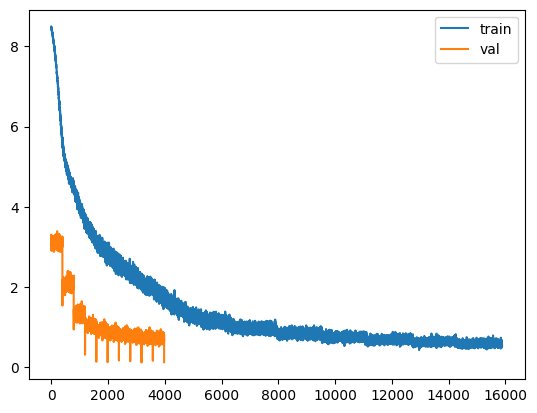

In [ ]:
import matplotlib.pyplot as plt

plt.plot(train_loss, label="train")
plt.plot(val_loss, label="val")
plt.legend()
plt.show()